In [1]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

from jax.example_libraries import optimizers

import optax

import matplotlib.pyplot as plt
from tqdm.notebook import trange
from functools import partial
from sklearn.datasets import fetch_openml

In [2]:
digits = fetch_openml(name='mnist_784', version=1);

/opt/conda/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [19]:
K = 50

n = 784
m = 512
num_itr = 40
adam_lr = 5e-5
max_inner = 50
A = jnp.array(np.random.randn(m, n))
gamma_opt = 1./jnp.max(JLA.eigvals(A.T@A))

In [20]:
xtrain = jnp.array(digits["data"])[:60000,:] / 255.
xtest = jnp.array(digits["data"])[60000:,:] / 255.

In [21]:
def train_loader(batch_size, head_idx=0, shuffle=True):
    if shuffle:
        idxs = jnp.array(np.random.randint(0, 60000, batch_size))
        return jnp.copy(xtrain[idxs, :].T)
    else:
        return jnp.copy(xtrain[head_idx:head_idx+batch_size, :].T)

def test_loader(batch_size, head_idx):
    return jnp.copy(xtrain[head_idx:head_idx+batch_size, :].T)

In [22]:
def mini_batch(K):
    x_org = train_loader(K)
    y = A@x_org
    return x_org,y

def test_mini_batch(K, idx):
    x_org = test_loader(K, idx)
    y = A@x_org
    return x_org, y

In [23]:
def show_img(x):
    n_data = 16
    row = 4
    col = 4
    fig, ax = plt.subplots(nrows=row, ncols=col,figsize=(8,6))

    fig.suptitle("MNIST data-set", fontsize=24)
    for i in range(n_data):
        _r= i//col
        _c= i%col
        ax[_r,_c].axes.xaxis.set_visible(False)
        ax[_r,_c].axes.yaxis.set_visible(False)
        ax[_r,_c].imshow(np.array(x[:,i]).reshape(28,28), cmap='bone')

In [24]:
x, _ = mini_batch(K)

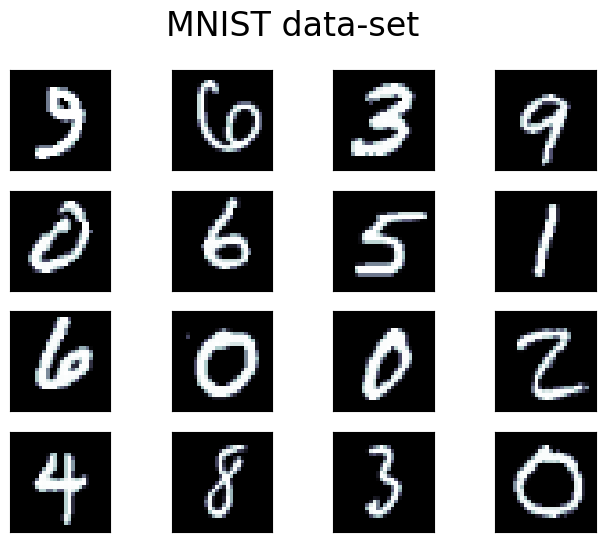

In [25]:
show_img(x)

In [26]:
def softshrink(x, tau):
    return jnp.sign(x) * jnp.max(jnp.append(jnp.abs(x) - tau, 0))
vec_softshrink = jax.jit(jax.vmap(softshrink, in_axes=[-1, None], out_axes=-1))

In [27]:
def ISTA(max_itr, y):
    x = jnp.zeros((n, K))
    for i in range(max_itr):
        x -= gamma_opt * A.T @ (A@x - y)
        x = vec_softshrink(x.reshape(1, -1), gamma_opt)
        x = x.real.reshape(n, K)
    return x

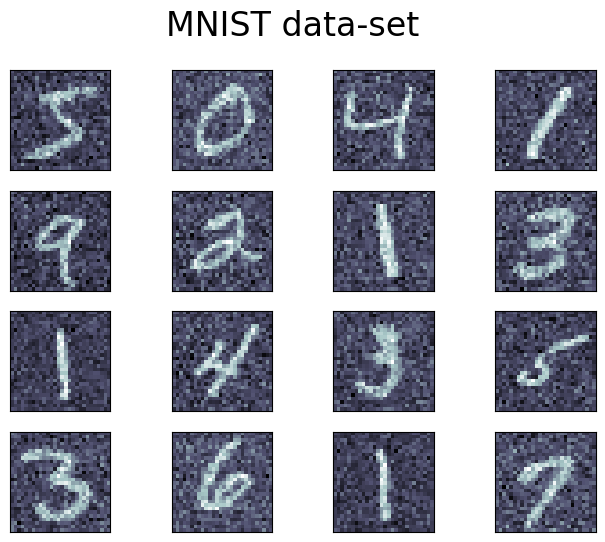

In [28]:
x_test,y_test = test_mini_batch(K, 0)
x_hat = ISTA(num_itr, y_test)
show_img(x_hat)

In [29]:
@partial(jax.jit, static_argnums=0)
def DU_ISTA(max_itr, y, gamma, alpha):
    x = jnp.zeros((n, K))
    for i in range(max_itr):
        x -= gamma[i] * A.T@(A@x -y)
        x = vec_softshrink(x.reshape(1, -1), alpha[i])
        x = x.reshape((n, K)).real
    return x

In [30]:
@jax.jit
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

In [31]:
@partial(jax.jit, static_argnums=1)
def loss(x_org, max_itr, y, gamma, alpha):
    x_hat = DU_ISTA(max_itr, y, gamma, alpha)
    return jnp.sum(batch_get_dot(x_org - x_hat))/K

In [32]:
# @partial(jax.jit, static_argnums=1)
# def loss(x_org, max_itr, y, gamma_and_alpha):
#     x_hat = DU_ISTA(max_itr, y, gamma_and_alpha)
#     return jnp.sum(batch_get_dot(x_org - x_hat))/K
# @partial(jax.jit, static_argnums=0)
# def DU_ISTA(max_itr, y, gamma_and_alpha):
#     x = jnp.zeros((n, K))
#     param_size = gamma_and_alpha.shape[0]
#     print(param_size)
#     for i in range(max_itr):
#         print(,gamma_and_alpha[i].shape)
#         x -= gamma_and_alpha[i] * A.T@(A@x -y)
#         x = vec_softshrink(x.reshape(1, -1), gamma_and_alpha[int(param_size/2)+i])
#         x = x.reshape((n, K)).real
#     return x
# opt_init, opt_update, get_params = optimizers.adam(adam_lr)

# @partial(jax.jit, static_argnums=1)
# def step(x, max_itr, y, step_num, opt_state):
#     value, grads = jax.value_and_grad(loss, argnums=-2)(x, max_itr, y, get_params(opt_state))
#     new_opt_state = opt_update(step_num, grads, opt_state)
#     return value, new_opt_state

# def train(params):
#     opt_state = opt_init(params)
#     for itr in trange(num_itr, leave=False):
#         for i in range(max_inner):
#             x, y = mini_batch(K)
#             value, opt_state = step(x, itr+1, y, i, opt_state)
#         print("\r"+"\rloss:{}".format(value), end=" ")
#     return get_params(opt_state)

In [33]:
# gamma_init = gamma_opt*jnp.ones(num_itr)
# alpha_init = gamma_opt*jnp.ones(num_itr)
# params_init = jnp.concat((gamma_init, alpha_init))

In [34]:
opt_init1, opt_update1, get_params1 = optimizers.adam(adam_lr)
opt_init2, opt_update2, get_params2 = optimizers.adam(adam_lr)

@partial(jax.jit, static_argnums=1)
def step(x_org, max_itr, y, step_num, opt_state1, opt_state2):
    tmp_eta = get_params1(opt_state1)
    tmp_mu = get_params2(opt_state2)
    value, grads = jax.value_and_grad(loss, argnums=-2)(x_org, max_itr, y, tmp_eta, tmp_mu)
    new_opt_state1 = opt_update1(step_num, grads, opt_state1)
    value, grads = jax.value_and_grad(loss, argnums=-1)(x_org, max_itr, y, tmp_eta, tmp_mu)
    new_opt_state2 = opt_update2(step_num, grads, opt_state2)
    return value, new_opt_state1, new_opt_state2

def train(gamma, alpha):
    opt_state1 = opt_init1(gamma)
    opt_state2 = opt_init2(alpha)
    for itr in trange(num_itr, leave=False):
        for i in range(max_inner):
            x, y = mini_batch(K)
            value, opt_state1, opt_state2 = step(x, itr+1, y, i, opt_state1, opt_state2)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params1(opt_state1), get_params2(opt_state2)

In [35]:
gamma_init = gamma_opt*jnp.ones(num_itr)
alpha_init = gamma_opt*jnp.ones(num_itr)
gamma_trained, alpha_trained = train(gamma_init, alpha_init)

  0%|          | 0/40 [00:00<?, ?it/s]

loss:51.78542709350586 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:41.137908935546875 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:37.35784912109375 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:32.4726448059082 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:34.37328338623047 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:31.82874870300293 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:27.30941390991211 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:24.79654884338379 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:27.455114364624023 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:22.31536102294922 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:19.208833694458008 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:23.790103912353516 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:21.28961181640625 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:23.907958984375 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:19.05411720275879 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:17.998476028442383 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:17.701744079589844 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:16.647939682006836 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:15.361852645874023 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:19.092819213867188 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:15.31423568725586 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:14.95731258392334 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:12.590944290161133 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:12.046853065490723 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:10.532732009887695 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:13.59518051147461 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:11.602471351623535 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:10.598981857299805 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:9.157618522644043 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:9.272337913513184 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:10.29901123046875 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:8.220673561096191 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:7.183472633361816 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:9.48825454711914 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:6.4937052726745605 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:4.796942710876465 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:6.424293518066406 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:6.11107873916626 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:5.615115165710449 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:6.457869529724121 

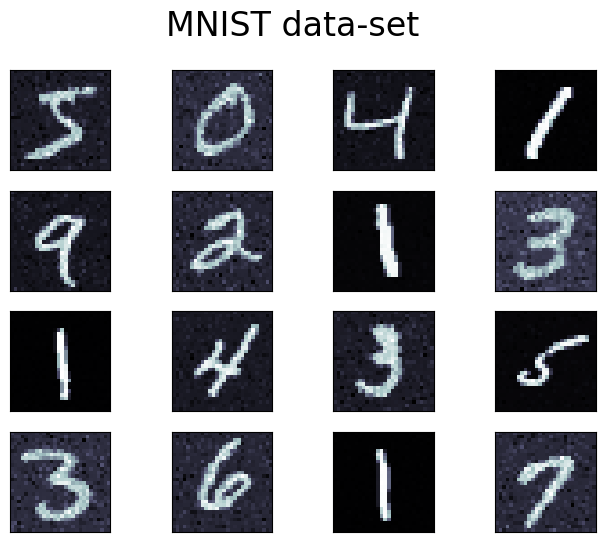

In [36]:
DU_x_hat = DU_ISTA(num_itr, y_test, gamma_trained, alpha_trained)
show_img(DU_x_hat)

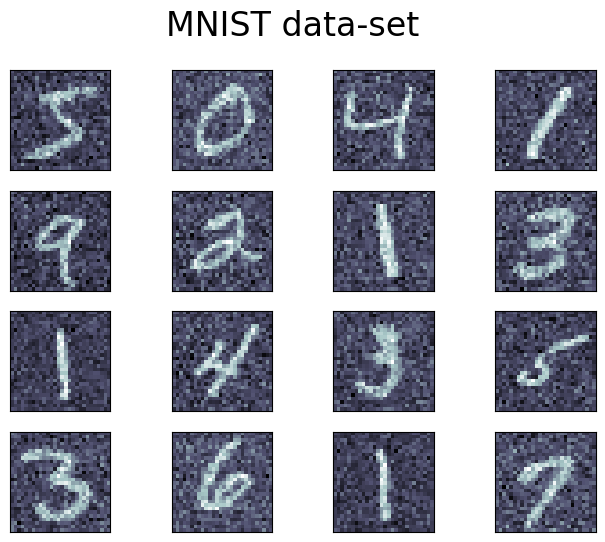

In [37]:
show_img(x_hat)